# Приведение 6 временных рядов к стационарности

Датасеты лежат в папке `Series/`:

- `monthly-sales-of-company-x-jan-6.csv`
- `monthly-boston-armed-robberies-j.csv`
- `international-airline-passengers.csv`
- `mean-monthly-air-temperature-deg.csv`
- `weekly-closings-of-the-dowjones-.csv`
- `daily-total-female-births-in-cal.csv`

В ноутбуке для каждого ряда:
1) строим графики и ACF/PACF,  
2) проверяем стационарность тестами **ADF** и **KPSS**,  
3) подбираем преобразование (лог/разности/сезонные разности),  
4) проверяем, что после преобразования ряд стационарен.


In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 4)

DATA_DIR = "Series"

from IPython.display import display


In [2]:
def load_series(path: str) -> pd.Series:
    """Загружает CSV с колонкой даты (Month/Date/Week) и значением."""
    df = pd.read_csv(path)
    # ищем колонку даты
    date_col = None
    for c in df.columns:
        if c.lower() in ["month", "date", "week"]:
            date_col = c
            break
    if date_col is None:
        date_col = df.columns[0]
    value_col = [c for c in df.columns if c != date_col][0]

    if date_col.lower() == "week":
        # ISO-week формат вида 1971-W27 -> берем понедельник этой недели
        idx = pd.to_datetime(df[date_col].astype(str) + "-1", format="%G-W%V-%u")
    else:
        idx = pd.to_datetime(df[date_col])

    y = pd.Series(df[value_col].astype(float).values, index=idx, name=os.path.basename(path))
    y = y.sort_index()
    return y


def adf_kpss(y: pd.Series, kpss_reg: str = "c") -> dict:
    """Возвращает ADF и KPSS для ряда (без NaN)."""
    yy = y.dropna()
    adf_stat, adf_p, *_ = adfuller(yy, autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(yy, regression=kpss_reg, nlags="auto")
    return {
        "adf_stat": adf_stat,
        "adf_p": adf_p,
        "kpss_stat": kpss_stat,
        "kpss_p": kpss_p,
        "n": len(yy),
    }


def plot_series(y: pd.Series, title: str):
    fig, ax = plt.subplots()
    y.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel("value")
    plt.show()


def plot_acf_pacf(y: pd.Series, lags: int, title_suffix: str = ""):
    yy = y.dropna()
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plot_acf(yy, lags=lags, ax=ax1)
    plot_pacf(yy, lags=lags, ax=ax2, method="ywm")
    ax1.set_title(f"ACF {title_suffix}")
    ax2.set_title(f"PACF {title_suffix}")
    plt.show()


def report_stationarity(y: pd.Series, name: str):
    res = adf_kpss(y)
    display(pd.DataFrame([res], index=[name]))

In [4]:
files = [
    "monthly-sales-of-company-x-jan-6.csv",
    "monthly-boston-armed-robberies-j.csv",
    "international-airline-passengers.csv",
    "mean-monthly-air-temperature-deg.csv",
    "weekly-closings-of-the-dowjones-.csv",
    "daily-total-female-births-in-cal.csv",
]

series = {f: load_series(os.path.join(DATA_DIR, f)) for f in files}

pd.DataFrame(
    [{"file": f, "start": s.index.min(), "end": s.index.max(), "n": len(s)} for f, s in series.items()]
)

,file,start,end,n
0,monthly-sales-of-company-x-jan-6.csv,1965-01-01,1971-05-01,77
1,monthly-boston-armed-robberies-j.csv,1966-01-01,1975-10-01,118
2,international-airline-passengers.csv,1949-01-01,1960-12-01,144
3,mean-monthly-air-temperature-deg.csv,1920-01-01,1939-12-01,240
4,weekly-closings-of-the-dowjones-.csv,1971-07-05,1974-08-05,162
5,daily-total-female-births-in-cal.csv,1959-01-01,1959-12-31,365


## Критерий «сделали стационарным»

Будем считать ряд стационарным (в прикладном смысле для ARIMA-подобных моделей), если:

- **ADF p-value < 0.05** (отвергаем единичный корень),
- **KPSS p-value > 0.05** (не отвергаем стационарность),
- визуально исчезает явный тренд/сезонность (после трансформации).

Важный нюанс: детерминированная сезонность формально нарушает «постоянство среднего», поэтому для сезонных рядов применяем **сезонное дифференцирование** (например, лаг 12 для месячных данных).


## monthly-sales-of-company-x-jan-6.csv

**Выбранное преобразование:** логарифмирование (стабилизируем дисперсию) + первая разность


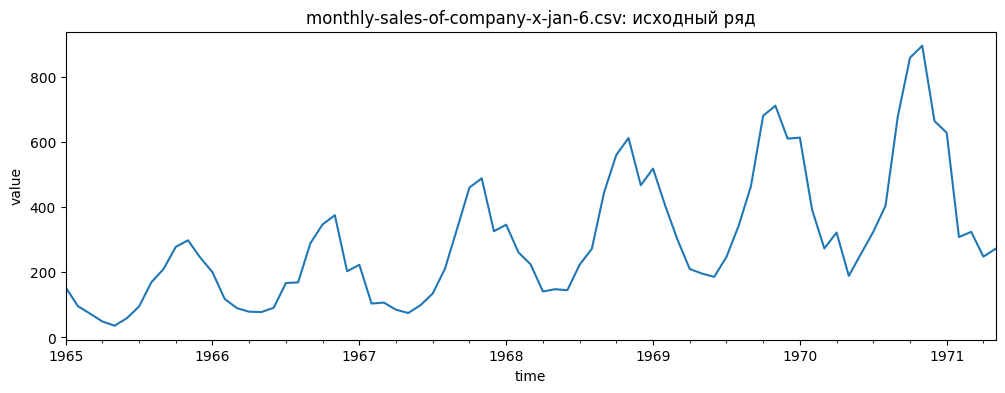

,adf_stat,adf_p,kpss_stat,kpss_p,n
raw,0.654715,0.988889,0.852438,0.01,77


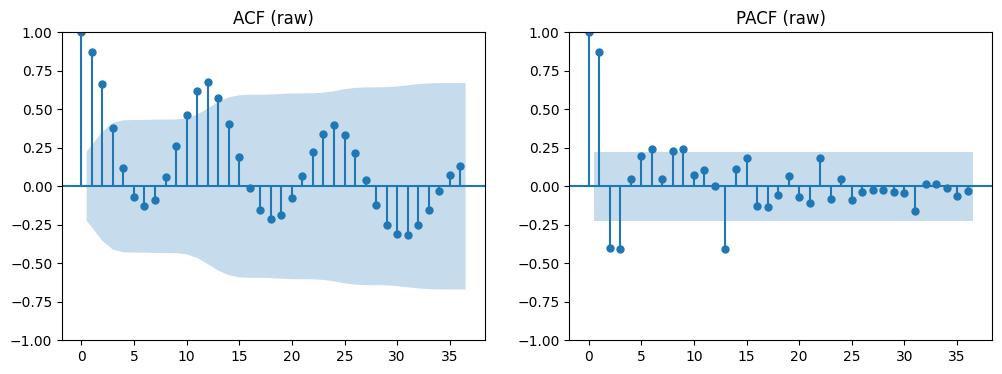

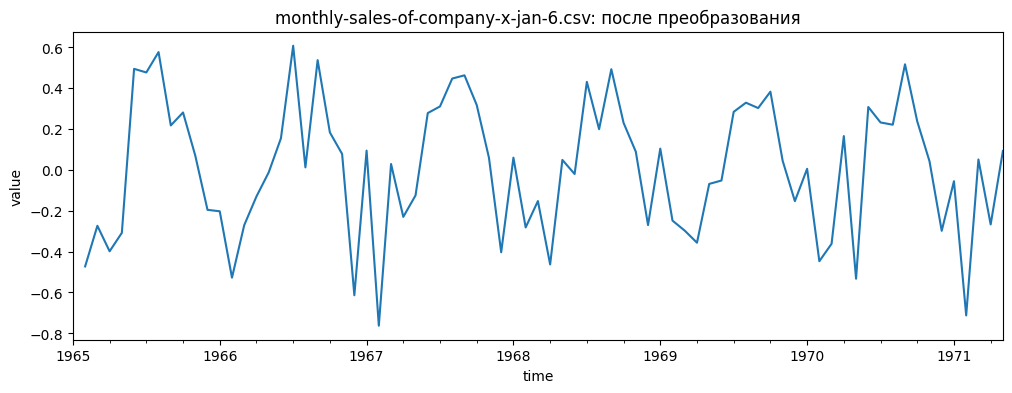

,adf_stat,adf_p,kpss_stat,kpss_p,n
transformed,-3.135644,0.024025,0.027067,0.1,76


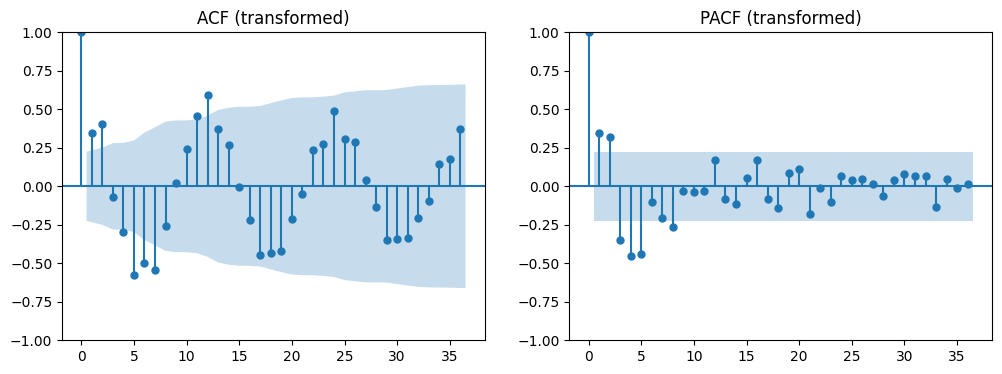

In [5]:
y = series["monthly-sales-of-company-x-jan-6.csv"]
plot_series(y, "monthly-sales-of-company-x-jan-6.csv: исходный ряд")
report_stationarity(y, "raw")
plot_acf_pacf(y, lags=36, title_suffix="(raw)")

# Преобразование
y_stationary = np.log(y).diff(1)

plot_series(y_stationary, "monthly-sales-of-company-x-jan-6.csv: после преобразования")
report_stationarity(y_stationary, "transformed")
plot_acf_pacf(y_stationary, lags=36, title_suffix="(transformed)")

## monthly-boston-armed-robberies-j.csv

**Выбранное преобразование:** логарифмирование + первая разность (убираем тренд и рост дисперсии)


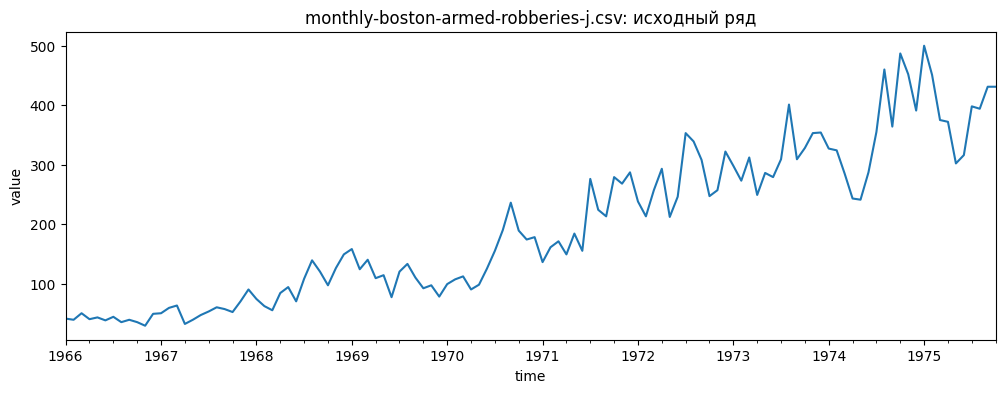

,adf_stat,adf_p,kpss_stat,kpss_p,n
raw,1.001102,0.994278,1.71187,0.01,118


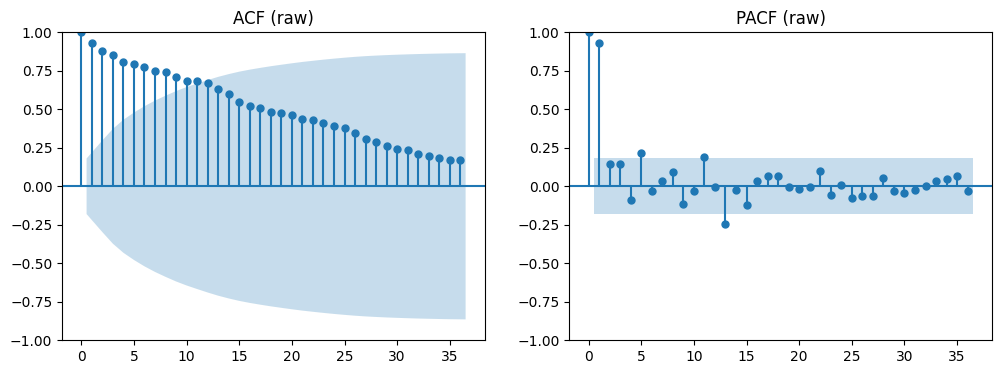

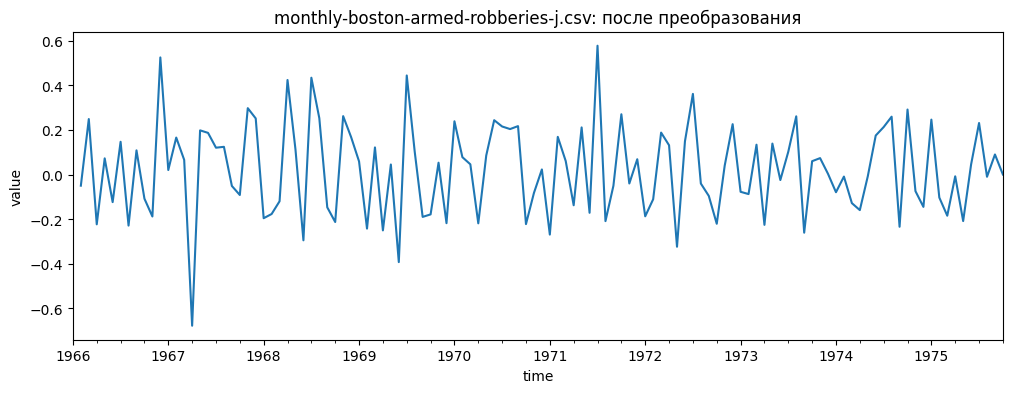

,adf_stat,adf_p,kpss_stat,kpss_p,n
transformed,-7.601792,2.378602e-11,0.089736,0.1,117


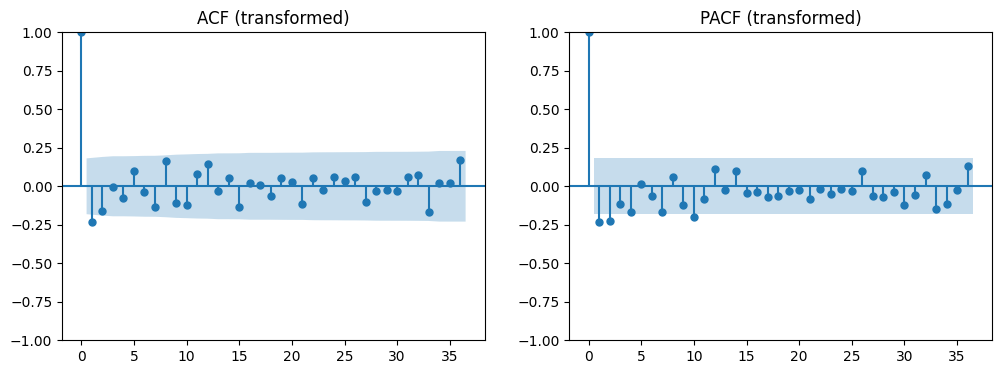

In [6]:
y = series["monthly-boston-armed-robberies-j.csv"]
plot_series(y, "monthly-boston-armed-robberies-j.csv: исходный ряд")
report_stationarity(y, "raw")
plot_acf_pacf(y, lags=36, title_suffix="(raw)")

# Преобразование
y_stationary = np.log(y).diff(1)

plot_series(y_stationary, "monthly-boston-armed-robberies-j.csv: после преобразования")
report_stationarity(y_stationary, "transformed")
plot_acf_pacf(y_stationary, lags=36, title_suffix="(transformed)")

## international-airline-passengers.csv

**Выбранное преобразование:** логарифмирование + сезонная разность (лаг 12) + первая разность


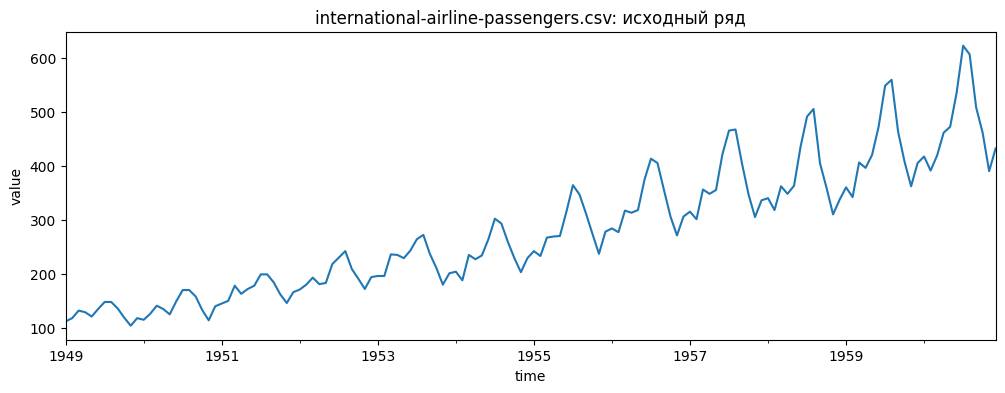

,adf_stat,adf_p,kpss_stat,kpss_p,n
raw,0.815369,0.99188,1.651312,0.01,144


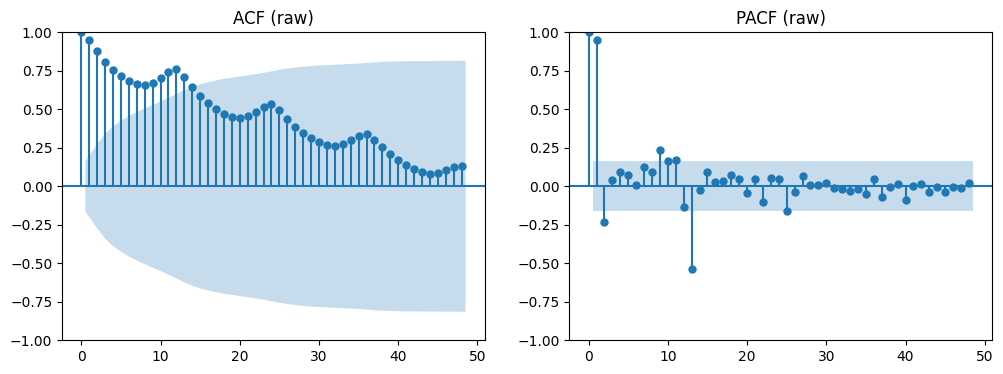

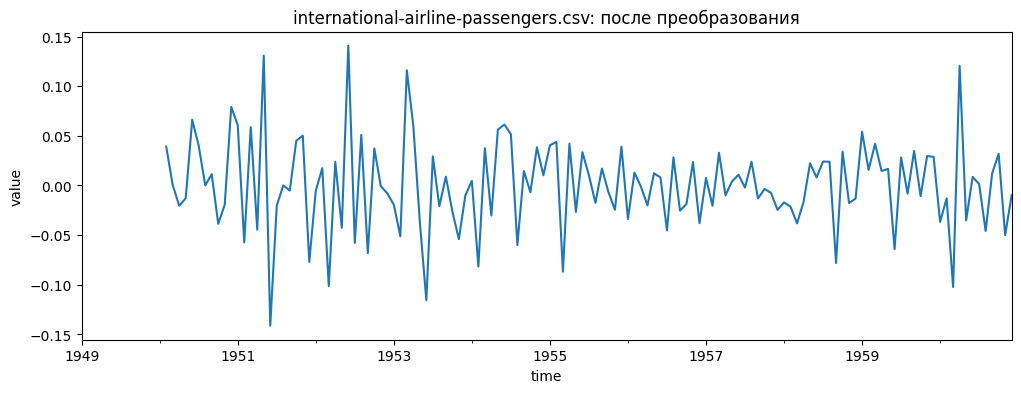

,adf_stat,adf_p,kpss_stat,kpss_p,n
transformed,-4.443325,0.000249,0.073191,0.1,131


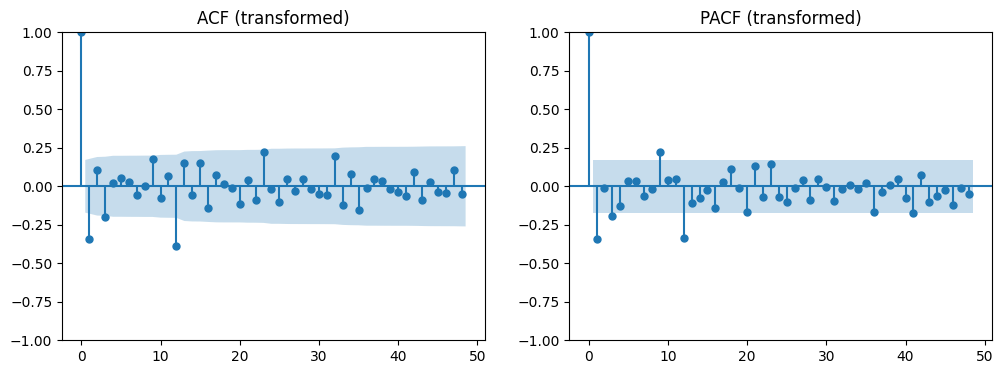

In [7]:
y = series["international-airline-passengers.csv"]
plot_series(y, "international-airline-passengers.csv: исходный ряд")
report_stationarity(y, "raw")
plot_acf_pacf(y, lags=48, title_suffix="(raw)")

# Преобразование
y_stationary = np.log(y).diff(12).diff(1)

plot_series(y_stationary, "international-airline-passengers.csv: после преобразования")
report_stationarity(y_stationary, "transformed")
plot_acf_pacf(y_stationary, lags=48, title_suffix="(transformed)")

## mean-monthly-air-temperature-deg.csv

**Выбранное преобразование:** сезонная разность (лаг 12), чтобы убрать сезонный цикл


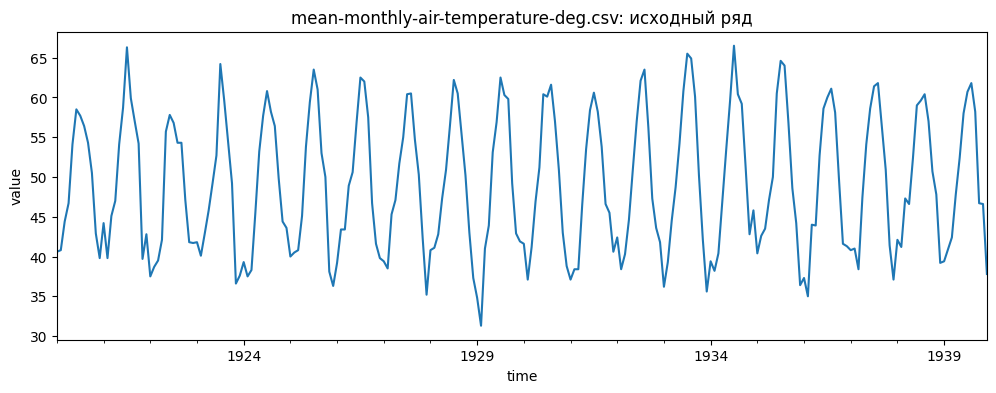

,adf_stat,adf_p,kpss_stat,kpss_p,n
raw,-3.255492,0.016989,0.04386,0.1,240


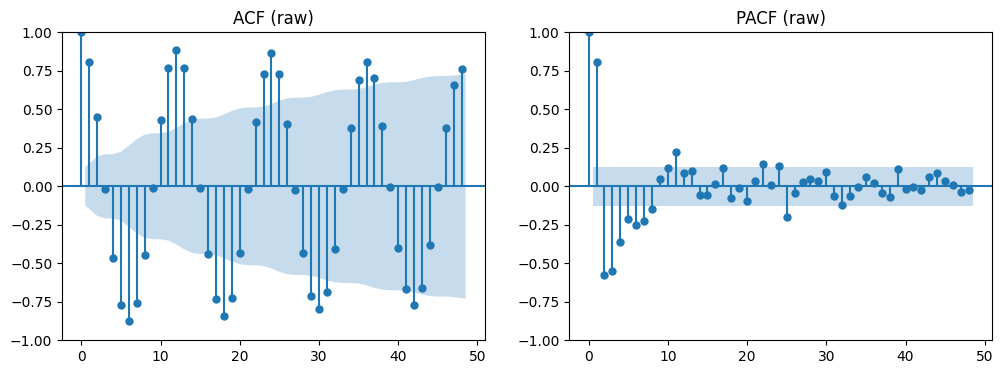

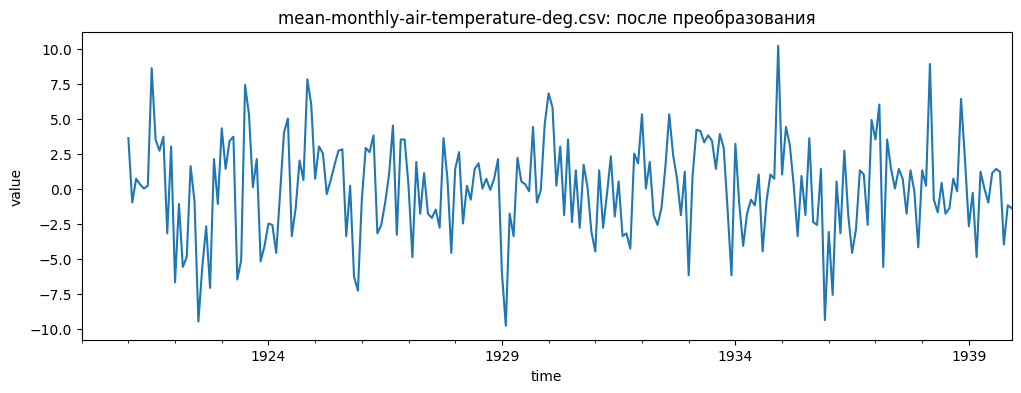

,adf_stat,adf_p,kpss_stat,kpss_p,n
transformed,-6.072501,1.141945e-07,0.026833,0.1,228


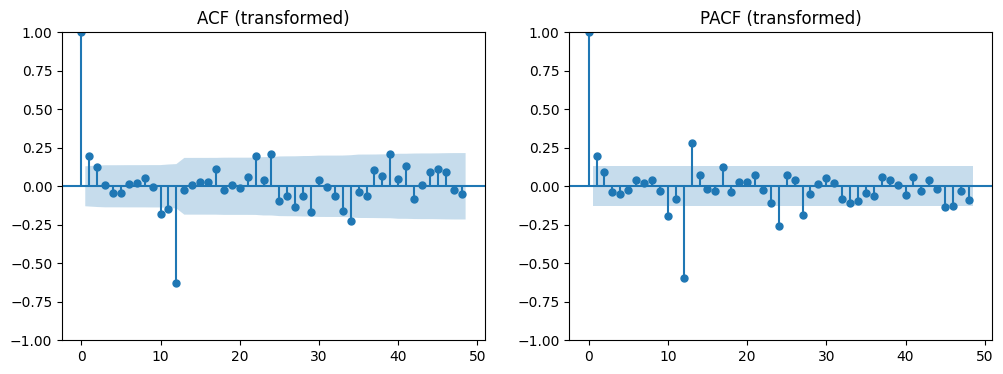

In [8]:
y = series["mean-monthly-air-temperature-deg.csv"]
plot_series(y, "mean-monthly-air-temperature-deg.csv: исходный ряд")
report_stationarity(y, "raw")
plot_acf_pacf(y, lags=48, title_suffix="(raw)")

# Преобразование
y_stationary = y.diff(12)

plot_series(y_stationary, "mean-monthly-air-temperature-deg.csv: после преобразования")
report_stationarity(y_stationary, "transformed")
plot_acf_pacf(y_stationary, lags=48, title_suffix="(transformed)")

## weekly-closings-of-the-dowjones-.csv

**Выбранное преобразование:** лог-доходности: первая разность логарифма (≈ процентные изменения)


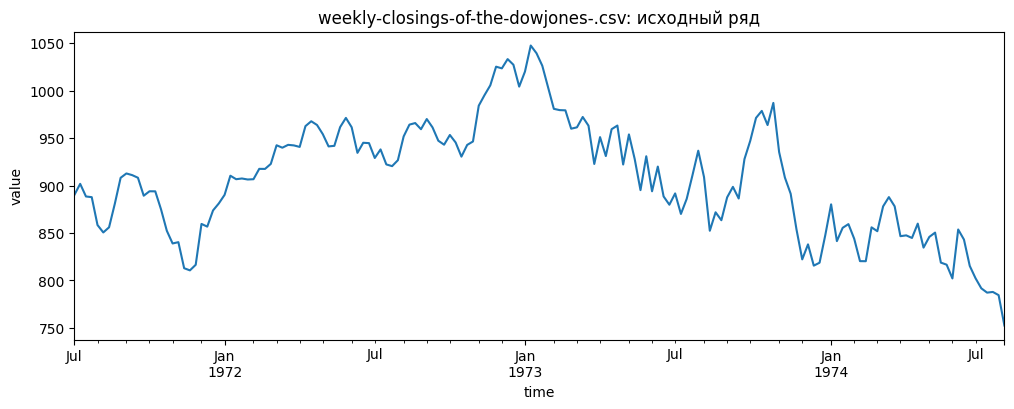

,adf_stat,adf_p,kpss_stat,kpss_p,n
raw,-1.314625,0.622455,0.58343,0.024143,162


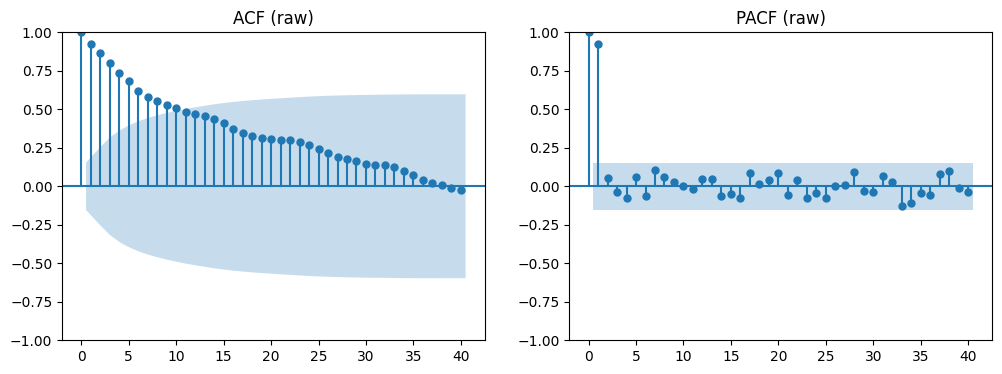

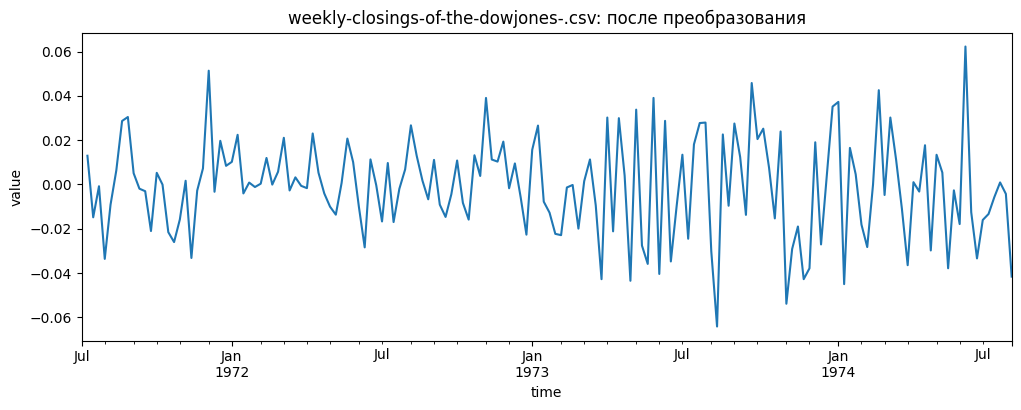

,adf_stat,adf_p,kpss_stat,kpss_p,n
transformed,-12.995821,2.751609e-24,0.198675,0.1,161


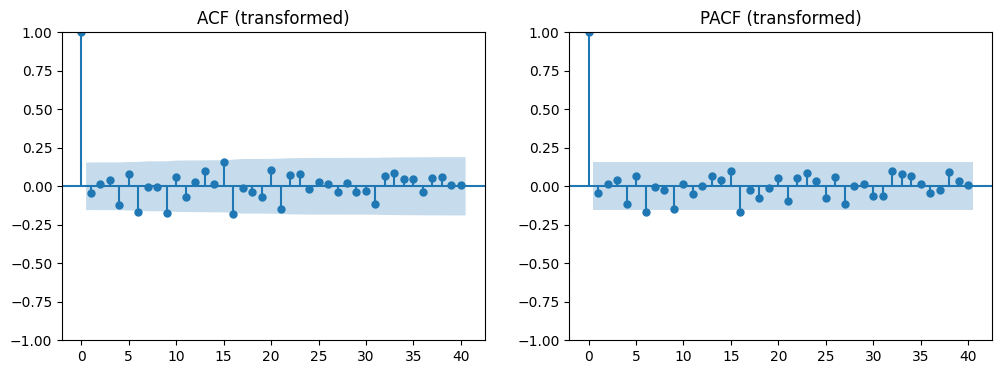

In [9]:
y = series["weekly-closings-of-the-dowjones-.csv"]
plot_series(y, "weekly-closings-of-the-dowjones-.csv: исходный ряд")
report_stationarity(y, "raw")
plot_acf_pacf(y, lags=40, title_suffix="(raw)")

# Преобразование
y_stationary = np.log(y).diff(1)

plot_series(y_stationary, "weekly-closings-of-the-dowjones-.csv: после преобразования")
report_stationarity(y_stationary, "transformed")
plot_acf_pacf(y_stationary, lags=40, title_suffix="(transformed)")

## daily-total-female-births-in-cal.csv

**Выбранное преобразование:** первая разность (для сглаживания возможных медленных сдвигов среднего)


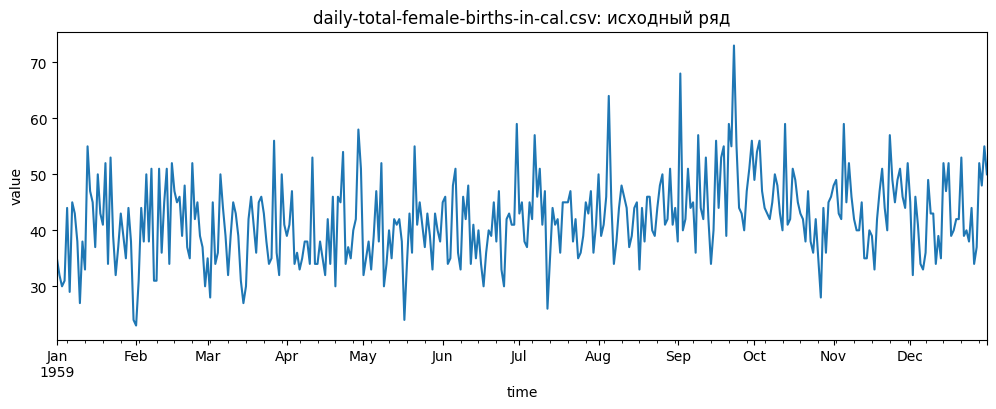

,adf_stat,adf_p,kpss_stat,kpss_p,n
raw,-4.808291,0.000052,1.612966,0.01,365


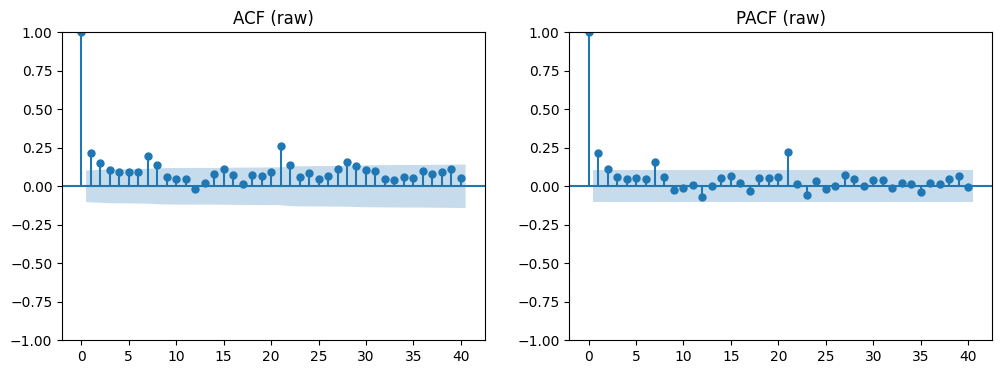

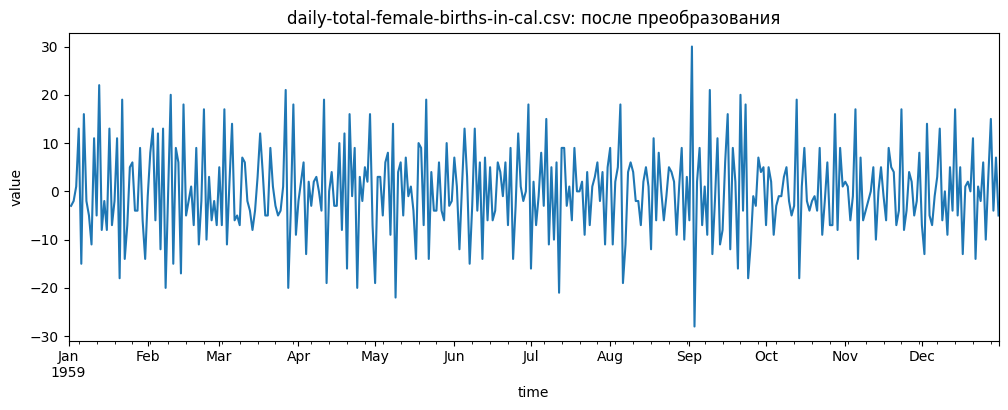

,adf_stat,adf_p,kpss_stat,kpss_p,n
transformed,-12.625179,1.547240e-23,0.187388,0.1,364


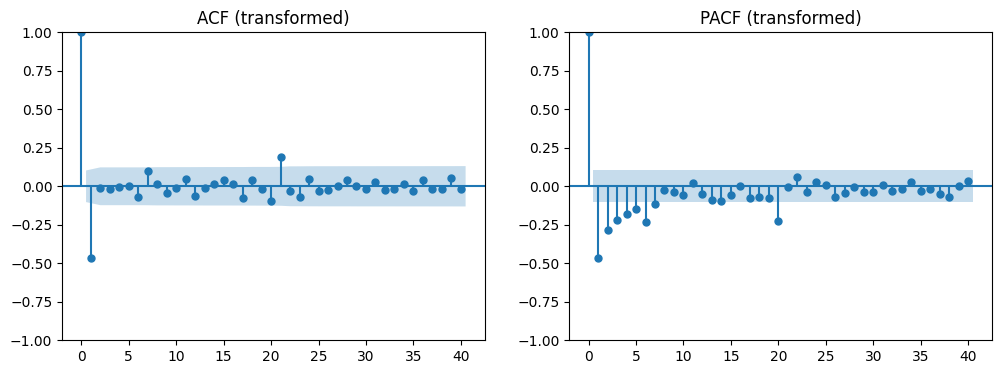

In [10]:
y = series["daily-total-female-births-in-cal.csv"]
plot_series(y, "daily-total-female-births-in-cal.csv: исходный ряд")
report_stationarity(y, "raw")
plot_acf_pacf(y, lags=40, title_suffix="(raw)")

# Преобразование
y_stationary = y.diff(1)

plot_series(y_stationary, "daily-total-female-births-in-cal.csv: после преобразования")
report_stationarity(y_stationary, "transformed")
plot_acf_pacf(y_stationary, lags=40, title_suffix="(transformed)")

## Итоговая таблица

Сводим результаты тестов до/после преобразования.


In [11]:
rows=[]
for f in files:
    y=series[f]
    raw=adf_kpss(y)
    # transformed (повторяем выбранные правила)
    if f in ["monthly-sales-of-company-x-jan-6.csv","monthly-boston-armed-robberies-j.csv","weekly-closings-of-the-dowjones-.csv"]:
        yt=np.log(y).diff(1)
        tname="log + diff(1)"
    elif f=="international-airline-passengers.csv":
        yt=np.log(y).diff(12).diff(1)
        tname="log + diff(12) + diff(1)"
    elif f=="mean-monthly-air-temperature-deg.csv":
        yt=y.diff(12)
        tname="diff(12)"
    elif f=="daily-total-female-births-in-cal.csv":
        yt=y.diff(1)
        tname="diff(1)"
    else:
        yt=y.copy()
        tname="raw"
    trans=adf_kpss(yt)
    rows.append({
        "file": f,
        "transform": tname,
        "raw_adf_p": raw["adf_p"],
        "raw_kpss_p": raw["kpss_p"],
        "trans_adf_p": trans["adf_p"],
        "trans_kpss_p": trans["kpss_p"],
        "n_raw": raw["n"],
        "n_trans": trans["n"],
    })
summary=pd.DataFrame(rows)
summary

,file,transform,raw_adf_p,raw_kpss_p,trans_adf_p,trans_kpss_p,n_raw,n_trans
0,monthly-sales-of-company-x-jan-6.csv,log + diff(1),0.988889,0.010000,2.402539e-02,0.1,77,76
1,monthly-boston-armed-robberies-j.csv,log + diff(1),0.994278,0.010000,2.378602e-11,0.1,118,117
2,international-airline-passengers.csv,log + diff(12) + diff(1),0.991880,0.010000,2.485912e-04,0.1,144,131
3,mean-monthly-air-temperature-deg.csv,diff(12),0.016989,0.100000,1.141945e-07,0.1,240,228
4,weekly-closings-of-the-dowjones-.csv,log + diff(1),0.622455,0.024143,2.751609e-24,0.1,162,161
5,daily-total-female-births-in-cal.csv,diff(1),0.000052,0.010000,1.547240e-23,0.1,365,364


## Примечания

- Для рядов с экспоненциальным ростом/ростом дисперсии (продажи, пассажиры, индексы, криминальная статистика) логарифмирование делает шум ближе к аддитивному и стабилизирует дисперсию.
- Для месячных рядов с выраженной сезонностью (пассажиры, температура) сезонная разность `diff(12)` убирает повторяющийся годовой цикл.
- Для финансового ряда (Dow Jones) интерпретируем `diff(log)` как доходности — это стандартное стационарное представление.